In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearnex import patch_sklearn
patch_sklearn()
import pyro
import numpy as np
import pylab as pl
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO, Predictive

sns.set_style("whitegrid")
sns.set(rc={'axes.facecolor':'#e6fdcb', 'figure.facecolor':'#b6d699'})
sns.set(font_scale=1.25)
sns.set_style("whitegrid")


from scripts import *
from models import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data = pd.read_csv("../Datasets/Avocado_prices_2020/avocado-updated-2020.csv", sep=",")

In [3]:
data.describe()

,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year
count,33045.000000,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,33045.000000
mean,1.379941,9.683997e+05,3.023914e+05,2.797693e+05,2.148255e+04,3.646735e+05,2.501980e+05,1.067329e+05,7.742585e+03,2017.460887
std,0.378972,3.934533e+06,1.301026e+06,1.151052e+06,1.001607e+05,1.564004e+06,1.037734e+06,5.167226e+05,4.819803e+04,1.699747
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000
25%,1.100000,1.511895e+04,7.673100e+02,2.712470e+03,0.000000e+00,9.121860e+03,6.478630e+03,4.662900e+02,0.000000e+00,2016.000000
50%,1.350000,1.291170e+05,1.099477e+04,2.343600e+04,1.780900e+02,5.322224e+04,3.687699e+04,6.375860e+03,0.000000e+00,2017.000000
75%,1.620000,5.058285e+05,1.190219e+05,1.352389e+05,5.096530e+03,1.744314e+05,1.206624e+05,4.041723e+04,8.044400e+02,2019.000000
max,3.250000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,3.168919e+07,2.055041e+07,1.332760e+07,1.403184e+06,2020.000000


In [4]:
# Check null values
data.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

In [5]:
# Convert date to datetime format
data["date"] = pd.to_datetime(data["date"])

In [6]:
# Sort data by date
data = data.sort_values(["date"], ascending=[True]) 

In [7]:
# Consider data of the whole US
avocado_us = data[data["geography"]=="Total U.S."]

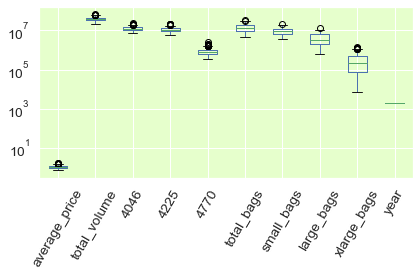

In [8]:
# Boxplot of the variables
fig = pl.figure()

sns.set(font_scale=1.25)
fig.patch.set_alpha(0.)

ax = fig.add_subplot(111)

sns.set(rc={'axes.facecolor':'#e6ffcc', 'figure.facecolor':'#b6d699'})
avocado_us[avocado_us["type"]=="conventional"].plot.box(ax=ax, rot=60)
ax.patch.set_facecolor('#e6ffcc')
ax.patch.set_alpha(1.)

ax.set_yscale("log")
pl.tight_layout()
fig.savefig('temp.png', facecolor=fig.get_facecolor(), dpi=200)

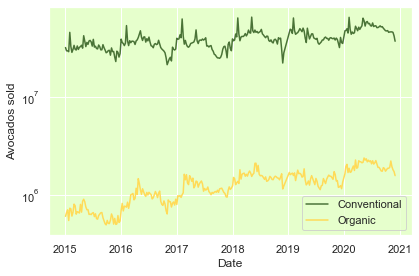

In [9]:
# Avocados sold per year
fig = pl.figure()
fig.patch.set_alpha(0.)
ax = fig.add_subplot(111)

plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "total_volume"]], ax, legend=["Conventional"])
plot_series(avocado_us[avocado_us["type"]=="organic"][["date", "total_volume"]], ax, legend=["Organic"])
ax.patch.set_facecolor('#e6ffcc')
ax.patch.set_alpha(1.)


ax.set_yscale("log")
pl.ylabel("Avocados sold")
pl.tight_layout()
fig.savefig('temp.png', facecolor=fig.get_facecolor(), dpi=200)
pl.show()

In [10]:
# Growth of avocado sales per year
from scipy.optimize import curve_fit

def f(x, c0, a):
    return c0*a**x

avocado_type = "organic"
c = avocado_us[avocado_us["type"]==avocado_type][["total_volume"]].to_numpy().ravel()

years = len(c) / 52.1429
xdata = np.linspace(0, years, c.shape[0])
popt, _ = curve_fit(f, xdata, c)
print(f"Growth of {avocado_type} avocado per year: {(popt[1] - 1)*100} %")

Growth of organic avocado per year: 19.91002931744401 %


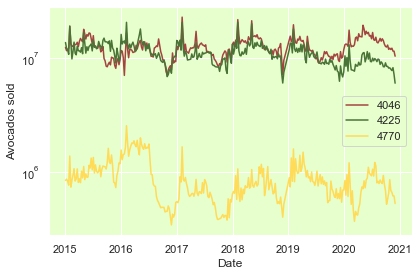

In [11]:
# Avocados sold by type over time
fig = pl.figure()

fig.patch.set_alpha(0.)

ax = fig.add_subplot(111)

plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "4046", "4225", "4770"]], ax)
ax.patch.set_facecolor('#e6ffcc')
ax.patch.set_alpha(1.)

ax.set_yscale("log")
pl.ylabel("Avocados sold")
pl.tight_layout()
fig.savefig('temp.png', facecolor=fig.get_facecolor(), dpi=200)
pl.show()

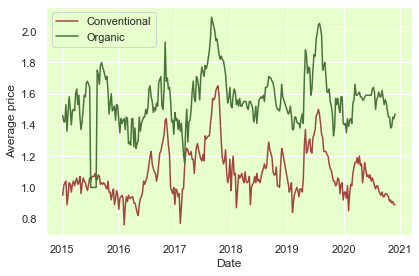

In [12]:
# Avocado price over time
fig = pl.figure()
fig.patch.set_alpha(0.)

ax = fig.add_subplot(111)

plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "average_price"]], ax, legend=["Conventional"])
plot_series(avocado_us[avocado_us["type"]=="organic"][["date", "average_price"]], ax, legend=["Organic"])
ax.patch.set_facecolor('#e6ffcc')
ax.patch.set_alpha(1.)

pl.ylabel("Average price")
pl.tight_layout()
fig.savefig('temp.png', facecolor=fig.get_facecolor(), dpi=200)
pl.show()

It seems that the Avocadopocalypse of 2017 was indeed real, the price grew to over 1.6$, a 50% increase from its mean of 1.08$

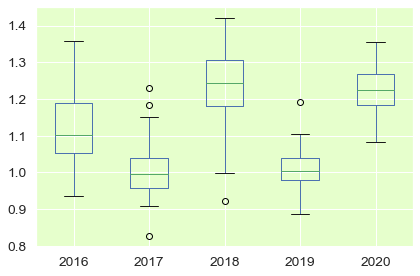

In [13]:
# Region by avocado sales
avocados_growth = pd.DataFrame(columns = set(data["geography"]))

for column in avocados_growth:
    region = data[(data["geography"]==column) & (data["type"]=="conventional")]
    avocados_per_year = region.groupby(region["date"].dt.year)["total_volume"].mean().to_numpy()
    avocados_growth[column] = avocados_per_year[1:] / avocados_per_year[:-1]

avocados_growth["year"] = np.sort(list(set(data["year"])))[1:]
avocados_growth = avocados_growth.set_index("year")

fig = pl.figure()

sns.set(font_scale=1.25)
fig.patch.set_alpha(0.)

ax = fig.add_subplot(111)

sns.set(rc={'axes.facecolor':'#e6ffcc', 'figure.facecolor':'#b6d699'})
avocados_growth.T.plot.box(ax=ax)
ax.patch.set_facecolor('#e6ffcc')
ax.patch.set_alpha(1.)

pl.tight_layout()
fig.savefig('temp.png', facecolor=fig.get_facecolor(), dpi=200)

## Gaussian process predictions

The power of the gaussian process is that it is hihly customizable by choosing different kernels or sum of kernels, furthermore it provides confidence bounds on predictions and any length predictions

In [14]:
y = avocado_us[avocado_us["type"]=="conventional"][["total_volume"]].to_numpy()
x = np.arange(y.shape[0], dtype=float).reshape(-1, 1)

y *= 1e-7
x *= 1e-2

y_train, y_test = y[:-52], y[-52:]
x_train, x_test = x[:-52], x[-52:]

In [15]:
x_train, x_val = x_train[:-52], x_train[-52:]
y_train, y_val = y_train[:-52], y_train[-52:]

In [16]:
model = HMC_GP()

model.fit(torch.tensor(x_train.ravel()), torch.tensor(y_train.ravel()))

Warmup:   0%|          | 0/60 [00:00, ?it/s]c:\Users\Lorenzo\Desktop\PML-Exam\Analysis\models\HMC_GP.py:26: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  kernels.Periodic(1, variance=torch.tensor([1.]), lengthscale=p["lp2"], period=p["p2"]))
S:\Anaconda\lib\site-packages\pyro\contrib\gp\kernels\isotropic.py:48: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
S:\Anaconda\lib\site-packages\pyro\contrib\gp\kernels\periodic.py:69: TracerWarning: Converting a tensor to a Python boolean might cau

In [20]:
model.predict(torch.tensor(x_test.ravel()))

RuntimeError: size mismatch, get 52, 52x52,202
                Trace Shapes:      
                 Param Sites:      
      kern0.kern0.lengthscale      
         kern0.kern0.variance      
kern0.kern1.kern0.lengthscale      
   kern0.kern1.kern0.variance      
     kern0.kern1.kern1.period      
kern0.kern1.kern1.lengthscale      
   kern0.kern1.kern1.variance     1
            kern1.lengthscale      
               kern1.variance      
          kern1.scale_mixture      
                Sample Sites:      
                      s1 dist     |
                        value     |
                      l1 dist     |
                        value     |
                      s2 dist     |
                        value     |
                      l2 dist     |
                        value     |
                     lp2 dist     |
                        value     |
                      p2 dist     |
                        value     |
                      s3 dist     |
                        value     |
                      l3 dist     |
                        value     |
                      m3 dist     |
                        value     |
                    etas dist     |
                        value  52 |
                     eta dist  52 |
                        value 202 |
                      mu dist     |
                        value     |
                   noise dist     |
                        value     |

In [101]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from IPython.display import clear_output

space  = [Real(1e-4, 1e4, "log-uniform", name='k1_constant'),
          Real(1e-4, 1e4, "log-uniform", name='k1_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k1_nu"),

          Real(1e-4, 1e4, "log-uniform", name='k2_constant'),
          Real(1e-4, 1e4, "log-uniform", name='k2_lengthscale'),
          Categorical([0.5, 1.5, 2.5, np.inf], name="k2_nu"),
          Real(1e-4, 1e4, "log-uniform", name='k2_sine_lengthscale'),

          Real(1e-4, 1e4, "log-uniform", name='k3_constant'),
          Real(1e-4, 1e4, "log-uniform", name='k3_lengthscale'),
          Real(1e-4, 1e4, "log-uniform", name='k3_alpha')]


def create_kernel(params):
    # General trend
    k1 = ConstantKernel(params["k1_constant"], "fixed") * Matern(params["k1_lengthscale"], "fixed", params["k1_nu"])
    # Year seasonality
    k2 = ConstantKernel(params["k2_constant"], "fixed") * Matern(params["k2_lengthscale"], "fixed", params["k2_nu"]) \
         * ExpSineSquared(params["k2_sine_lengthscale"], 52*1e-2)
    # Mid term irregularities
    k3 = ConstantKernel(params["k3_constant"], "fixed") * RationalQuadratic(params["k3_lengthscale"], params["k3_alpha"], "fixed", "fixed")
    # Noise
    k4 = WhiteKernel()
    
    return k1 + k2 + k3 + k4

@use_named_args(space)
def objective(**params):
    clear_output(wait=True)

    kernel = create_kernel(params)

    model = GaussianProcessRegressor(kernel, n_restarts_optimizer=1, normalize_y=True).fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return np.mean((y_pred - y_val)**2)

res_gp = gp_minimize(objective, space, n_calls=30, verbose=True, n_jobs=1)

/home/lettera/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.8137
Function value obtained: 0.9157
Current minimum: 0.4046


k1_constant : 146.1974489629875
k1_lengthscale : 65.0064007053289
k1_nu : 2.5
k2_constant : 0.9662509452015552
k2_lengthscale : 10000.0
k2_nu : 2.5
k2_sine_lengthscale : 0.2605197322701201
k3_constant : 1.3742968040626986
k3_lengthscale : 0.0066493244244901556
k3_alpha : 0.0040752171246013795


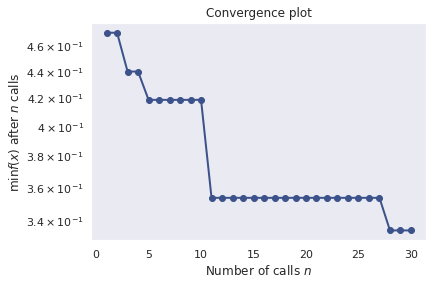

In [88]:
from skopt.plots import plot_convergence
print_optimum(space, res_gp)
plot_convergence(res_gp)
pl.yscale("log")

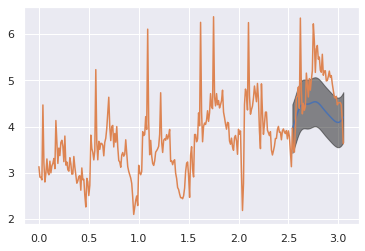

In [103]:
def params_to_dict(space, bayes_opt_result):
    params_dict = dict()
    for var, value in zip(space, bayes_opt_result.x):
        params_dict[var.name] = value

    return params_dict

def print_optimum(space, bayes_opt_result):
    for var, value in zip(space, bayes_opt_result.x):
        print(var.name, ":", value)

def plot_gp(model):
    t = x_test[:, 0]

    y_pred, y_std = model.predict(t.reshape(-1, 1), return_std=True)

    y_pred = y_pred.ravel()

    pl.fill_between(t, y_pred - y_std, y_pred + y_std, alpha=0.5, color='k')
    pl.plot(t, y_pred)
    pl.plot(x, y)

kernel = create_kernel(params_to_dict(space, res_gp))

model = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, normalize_y=True).fit(x[:-52], y[:-52])

plot_gp(model)


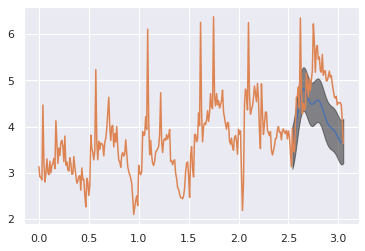

In [68]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel, Matern, DotProduct, Exponentiation

# General trend
k1 = ConstantKernel(0.009847046470162862, "fixed") * Matern(1.3776056445974685, "fixed", nu=1.5)
# Year seasonality
k2 = ConstantKernel(17.515722223970137, "fixed") * Matern(24.49957258073102, "fixed", nu=2.5) * ExpSineSquared(2.0872063839876716, 52*1e-2, "fixed", "fixed")
# Mid term irregularities
k3 = ConstantKernel(1.2270786269373, "fixed") * RationalQuadratic(0.011692649823412426, 0.0013146815023358132, "fixed", "fixed")
# Noise
k4 = WhiteKernel()
kernel = k1+k2+k3+k4

model = GaussianProcessRegressor(kernel, n_restarts_optimizer=1, normalize_y=True).fit(x[:-52], y[:-52])

plot_gp(model)